# Backtesting 

### MGMT 638: Data-Driven Investments: Equity
### Kerry Back, Rice University

<a target="_blank" href="https://colab.research.google.com/github/kerryback/mgmt638/blob/main/notebooks/11-backtest.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

## Read data

- Penny stocks have been eliminated
- Data includes both large caps and small caps.  You can filter to small caps if you want.
- Filter to your sector.

In [1]:
import pandas as pd

url = "https://www.dropbox.com/s/lm4v48d51g64l0f/data-2023-11-29.csv?dl=1"
df = pd.read_csv(url)

In [10]:
# uncomment and execute the following to filter to small caps

"""    
df["rnk"] = df.groupby("date", group_keys=False).marketcap.rank(
    ascending=False, 
    method="first"
)
df = df[(df.rnk>1000) & (df.rnk<=3000)]
df = df.drop(columns=["rnk"])
"""

'    \ndf["rnk"] = df.groupby("date", group_keys=False).marketcap.rank(\n    ascending=False, \n    method="first"\n)\ndf = df[(df.rnk>1000) & (df.rnk<=3000)]\ndf = df.drop(columns=["rnk"])\n'

In [11]:
sector = "Healthcare"
df = df[df.sector==sector]

## Define model and target

- Current code uses max_depth=4 and n_estimators=200
- Two possible targets: return in excess of the median or rank of the return.
- Comment one of them out.

In [12]:
from sklearn.ensemble import RandomForestRegressor
forest = RandomForestRegressor(max_depth=4, n_estimators=200)


df["target"] = df.groupby("date", group_keys=False).ret.apply(
    lambda x: 100 * (x-x.median())
)

""" 
# could use this instead

df["target"] = df.groupby("date", group_keys=False).ret.apply(
    lambda x: 100 * x.rank(pct=True)
)
"""



' \n# could use this instead\n\ndf["target"] = df.groupby("date", group_keys=False).ret.apply(\n    lambda x: 100 * x.rank(pct=True)\n)\n'

## Define predictors (features)

- Leaving out interactions with market volatility, because they didn't seem to make much difference.

In [13]:
features = [
    "marketcap", 
    "pb", 
    "mom", 
    "volume", 
    "volatility", 
    "roe", 
    "accruals",
    "agr"
]
features.sort()

## Define training dates and training windows

- Start training once we have three years of data.
- Specify num_years_for_training $\ge 3$ as the number of years of past data to train on in each iteration of the backtesting loop.

In [14]:
num_years_for_training = 5

In [15]:
dates = list(df.date.unique())
dates.sort()
train_dates = dates[156::52]  # once per year starting after three years

past_dates = {}               # dates on which to train for each training date
future_dates = {}             # dates for which to predict for each training date
for date in train_dates:
    start_index = dates.index(date) - 52*num_years_for_training
    start_index = start_index if start_index >= 0 else 0
    past_dates[date] = dates[start_index:dates.index(date)]
    if date < train_dates[-1]:
        future_dates[date] = dates[dates.index(date):(dates.index(date)+52)]
    else:
        future_dates[date] = dates[dates.index(date):]

## Run the loop

In [16]:
new_data = None
for date in train_dates:
    past = past_dates[date]
    past = df[df.date.isin(past)]
    future = future_dates[date]
    future = df[df.date.isin(future)]
    forest.fit(X=past[features], y=past.target)
    predictions = forest.predict(X=future[features])
    predictions = pd.DataFrame(predictions)
    predictions.columns = ["predict"]
    for col in ["ticker", "date"]:
        predictions[col] = future[col].to_list()
    new_data = pd.concat((new_data, predictions))
    
df = df.merge(new_data, on=["ticker", "date"], how="inner")

In [49]:
future.date.max()

'2023-11-17'

## Calculate portfolio returns

- Specify how many stocks you want to hold in each (long or short) portfolio

In [17]:
numstocks = 50

In [18]:
df["rnk_long"] = df.groupby("date", group_keys=False).predict.rank(
    ascending=False,
    method="first"
)
df["rnk_short"] = df.groupby("date", group_keys=False).predict.rank(
    ascending=True,
    method="first"
)


longs = df[df.rnk_long<=numstocks]
shorts = df[df.rnk_short<=numstocks]

In [19]:
long_ret = longs.groupby("date").ret.mean()
short_ret = shorts.groupby("date").ret.mean()
print(f"mean annualized long return is {52*long_ret.mean():.2%}")
print(f"mean annualized short return is {52*short_ret.mean():.2%}")

mean annualized long return is 24.00%
mean annualized short return is -24.55%


## Analyze fitted model on most recent data

In [53]:
present = future[future.date==future.date.max()]
medians = present[features].median()
medians = pd.DataFrame(medians).T

In [54]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

def predict1(char):
    data = medians.copy()
    grid = np.linspace(
        present[char].quantile(0.01), 
        present[char].quantile(0.99), 
        100
    )
    predictions = []
    for x in grid:
        data[char] = x
        prediction = forest.predict(X=data).item()
        predictions.append(prediction)
    return grid, predictions

In [55]:
def predict2(char1, char2):
    data = medians.copy()
    grid1 = np.linspace(
        present[char1].quantile(0.005), 
        present[char1].quantile(0.995), 
        20
    )
    grid2 = np.linspace(
        present[char2].quantile(0.01), 
        present[char2].quantile(0.99), 
        20
    )
    grid1, grid2 = np.meshgrid(grid1, grid2)
    predictions = np.empty(grid1.shape)
    for i in range(20):
        for j in range(20):
            data[char1] = grid1[i, j]
            data[char2] = grid2[i, j]
            predictions[i, j] = forest.predict(data)
    return grid1, grid2, predictions

### Feature importances

In [56]:
importances = pd.Series(forest.feature_importances_, index=features)
importances.sort_values(ascending=False).round(3)

pb            0.385
marketcap     0.152
volume        0.136
agr           0.094
volatility    0.086
mom           0.074
accruals      0.057
roe           0.016
dtype: float64

### Vary one characteristic at a time and plot

- Specify which characteristic

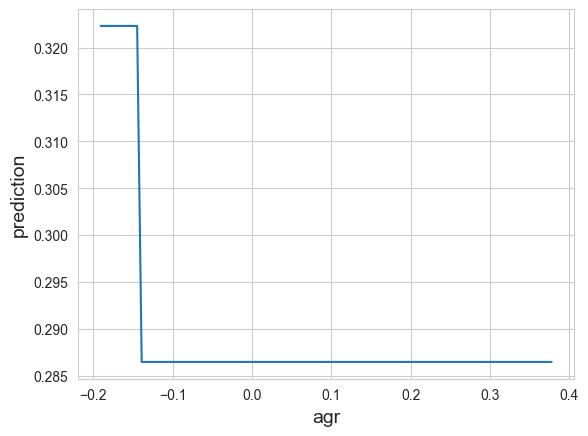

In [60]:
char = "agr"

grid, predictions = predict1(char)
plt.plot(grid, predictions)
plt.xlabel(char,  fontdict={"size": 14})
plt.ylabel("prediction",  fontdict={"size": 14})
plt.show()

### Vary two characteristics at a time and plot

- Specify which characteristics

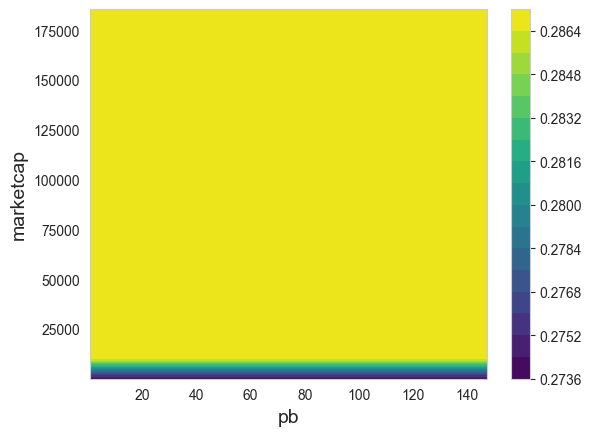

In [40]:
char1 = "pb"  
char2 = "marketcap"  

grid1, grid2, predictions = predict2(char1, char2)
contour = plt.contourf(grid1, grid2, predictions, 20, cmap="viridis")
cbar = plt.colorbar(contour)
plt.xlabel(char1, fontdict={"size": 14})
plt.ylabel(char2, fontdict={"size": 14})
plt.show()